* FT: Fourier transform
* DFT: Discrete Fourier transform; Implementations are usually labelled as FFT: fast Fourier transform, using symmetries to speed up the calculation


# Two independent issues
There are two independent issues that affect the Fourier space operation implementations in ip_diffim:
* Padding of images and kernels in order to be able to do convolution in Fourier space.
* Shifting higher values to the high frequency range before FFT/IFFT transformations then shifting the result back in order to achieve higher floating point accuracy for _edges_ in the image.

## Numerical precision: 

DFT/IDFT: They are series expansion-like transformations. Floating point errors accumulate (~ floating point epsilon * No. of pixels) Low values: higher relative error. 

Location of edges determined by high frequency components. We care more about edges than about the average offset values across the whole image.

We want the IDFT transformation to have high values in the high frequency part. We can use the special case of shifting by half the Fourier transformed image.

# Some Properties of DFT

1. Both sides of the transformation are periodic. All translations are with circular boundaires.
2. In discrete space, we have a fixed frequency resolution, and the transformation behaves as the input were periodical. This frequency resolution for the discrete image just fulfills the Nyqist criterion. The center frequency: is 1/2 (where pixels are unit size) in the even case.

    f = [0, 1, ...,   n/2-1,     -n/2, ..., -1] / (d*n)   if n is even
    
    f = [0, 1, ..., (n-1)/2, -(n-1)/2, ..., -1] / (d*n)   if n is odd

    In the odd case, the highest frequency is below the Nyqist frequency: information loss. Increase dataset to even. (Also FFT implementations work better.)
    
3. Translation in one space is phase shifting of components in the other space. Specially, shifting by half (np.fftshift) in one space is sign oscillation ($\pi$ phase shift) in the other space ($x=0 .. M-1, y= 0.. N-1$), N,M even:

$$(-1)^{x+y} f[x,y] = F [ u- M/2, v- N/2 ]$$
$$f[x - M/2, y - N/2 ] = (-1)^{u+v} F [u,v]$$
and vice versa.




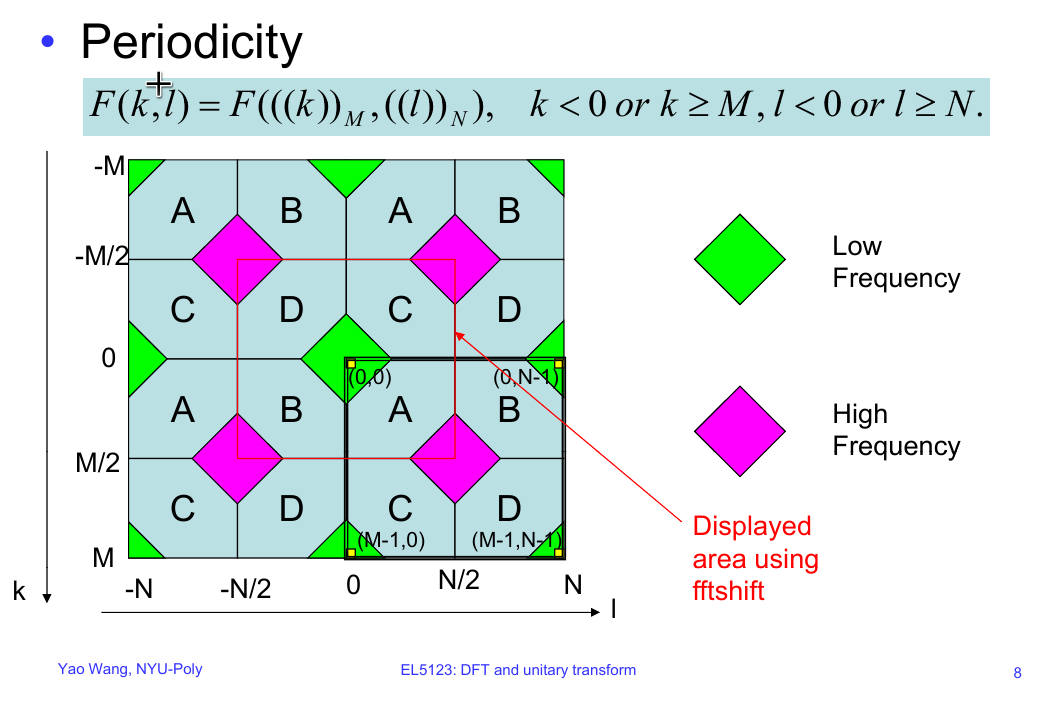
Image taken from [lecture notes](http://eeweb.poly.edu/~yao/EL5123/lecture6_2D_DFT.pdf).

# Some properties of convolution

1. Convolution commutes with _translation_:

$$T(f*g) = f*(Tg)$$

2. Discrete circular and linear convolutions are equal if the input datasets are padded at least to $N_1 + N_2 -1$ length with zeros at the end.

# Convolution theorem in discrete case 

Multiplication in discrete Fourier space is equal to circular convolution in real space.
If we want linear convolution instead of circular, we need to pad the datasets with extra space at the end(s) to avoid overlapping due to the periodicity of the inputs.

# Conclusions

* Pad to even size. Even size is well defined for both the FT transformation and shifting of frequencies. Odd size DFT has implementation and information loss concerns in general. Also, for half shifts, odd size is error prone due to the 1 size difference of the image quarters.
* PSF kernel should be centered around zero which is in the four corners of the image. Avoid shifting PSF kernels into the center of an image before FT: it will add a translation effect and phase oscillation if Fourier space; and won't shift it to high frequencies.
* A zero padded PSF up to the image size can usually be avoided in real space only operations. But not in Fourier space. The image and PSF sizes must be matched by zero padding before FT, as in Fourier space it is no longer zero padding. FT(padded kernel) != pad(FT(kernel)) 
* Also, after some Fourier space operations on FT(padded kernel), the result usually cannot be transformed back to real space as a small image but will remain nonzero accross the whole image. 
* Note: IDFT(func(DFT(small kernel))) cannot be applied to a "large image", not even in real space. DFT(small kernel) and DFT(large image) are different dimension Fourier spaces.

# References

- [Lecture notes: Yao Wang Polytechnic Institute of NYU, Brooklyn, NY 11201](http://eeweb.poly.edu/~yao/EL5123/lecture6_2D_DFT.pdf).

- [Lecture notes2](http://www.di.univr.it/documenti/OccorrenzaIns/matdid/matdid027832.pdf)

- [Lecture notes: Digital Image Processing pg. 209-210](https://ion.uwinnipeg.ca/~sliao/Courses/7205/Chapter%2004.pdf) The very same pages can be found in the book Gonzalez & Woods: Digital Image Processing.


------------

We demonstrate these statements here in this notebook.

In [1]:
# Use this for interactive plots; 
# too plots left in the interactive state can eat up resources

#%matplotlib notebook


%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
from scipy import stats
#from astropy.visualization import ZScaleInterval

In [2]:
# Some plotting routines. All images are (0,0) in bottom left.
def plotF(D):
    """4 panel plot of a Fourier transform. 
    Real, Imaginary, Log(abs(x)) and phase of the complex arrays."""
    fig = plt.figure()
    ax = fig.add_subplot(2, 2, 1)
    ax1img = ax.imshow(np.real(D), origin='bottom')
    fig.colorbar(ax1img, ax=ax)

    ax2=fig.add_subplot(2, 2, 2)
    ax2img = ax2.imshow(np.imag(D), origin='bottom')
    fig.colorbar(ax2img,ax=ax2)

    ax3 = fig.add_subplot(2, 2, 3)
    ax3img = ax3.imshow(np.log10(np.abs(D)+1e-20), origin='bottom',cmap='Blues_r')
    fig.colorbar(ax3img,ax=ax3)

    ax4 = fig.add_subplot(2, 2, 4)
    ax4img = ax4.imshow(np.angle(D), origin='bottom')
    fig.colorbar(ax4img, ax=ax4)

def singlePlot(D,zscale=False):
    """1 panel plot of an array"""
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    if zscale:
        vmin, vmax = ZScaleInterval().get_limits(D)
        cmap = 'Greys_r'
    else:
        vmin = None
        vmax = None
        cmap = None
    aximg = ax.imshow(D, origin='bottom',vmin=vmin, vmax=vmax, cmap=cmap)
    plt.colorbar(aximg)
    
def singlePlotLog(D,minVal=1e-20):
    """1 panel logarithmic plot of the absolute value of a (real or complex)
    array."""
    fig = plt.figure()
    ax = fig.add_subplot(1,1,1)
    aximg = ax.imshow(np.log10(np.abs(D)+minVal), 
                      origin='bottom', cmap='Blues_r')
    plt.colorbar(aximg)    

def putSrc(D,S,coords):
    """Put S into D at coordinate pairs given in coords. No edge handling."""
    xs, ys = S.shape
    xshalf = xs//2
    yshalf = ys//2
    for (xc, yc, amp) in coords:
        D[yc-yshalf:yc-yshalf+ys, xc-xshalf:xc-xshalf+xs] = S*amp
    
def genImg():
    """Generate an image with 3 sources."""
    # 0th (first) axis is y direction, 1st (second) is x direction
    yy,xx = np.mgrid[-1:1:0.1,-1:1:0.1]
    pos = np.empty(xx.shape + (2,))
    pos[:,:,0] = xx
    pos[:,:,1] = yy
    dist = stats.multivariate_normal([0,0],[[0.04,0],[0,0.04]])
    S = dist.pdf(pos)

    R = np.zeros((181,181),dtype=float)
    putSrc(R,S,((20,15,1),(50,50,2),(100,150,3),(150,50,4)))
    return R

# Low and high freq components of a single image
We demonstrate the zero point and the shift effects here

In [3]:
# 0th (first) axis is y direction, 1st (second) is x direction
yy,xx = np.mgrid[-1:1:0.1,-1:1:0.1]
pos = np.empty(xx.shape + (2,))
pos[:,:,0] = xx
pos[:,:,1] = yy
dist = stats.multivariate_normal([0,0],[[0.1,0],[0,0.1]])
tDGauss = dist.pdf(pos)
# tDGauss 2D Gauss in the center of the image

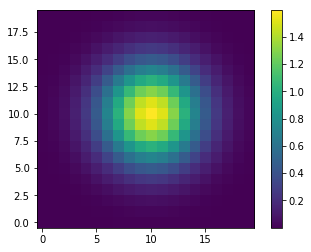

In [4]:
singlePlot(tDGauss)

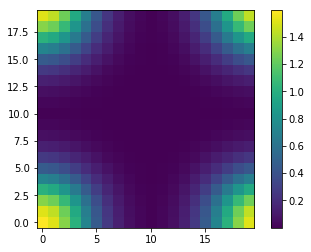

In [5]:
# Zero center around the corners
ZCentered = np.fft.fftshift(tDGauss)
fig=plt.figure()
ax=fig.add_subplot(1,1,1)
aximg = ax.imshow(ZCentered,origin='bottom')
plt.colorbar(aximg)

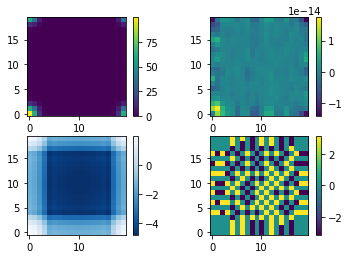

In [6]:
# A zero cenetered Gaussian is a (inverse width) Gausssian in Fourier space
# with no phase, i.e. all real numbers
D = np.fft.fft2(ZCentered)
plotF(D)

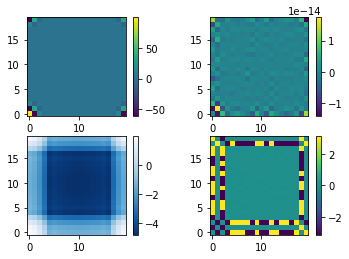

In [7]:
D = np.fft.fft2(tDGauss)
plotF(D)

---------

## Shift to high frequency in Fourier space

In [8]:
SH = np.ones(tDGauss.shape)
SH[::2,:] = -1
SH[:,::2] *= -1
HFGauss = ZCentered * SH
SH[:5,:5]

array([[ 1., -1.,  1., -1.,  1.],
       [-1.,  1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.,  1.],
       [-1.,  1., -1.,  1., -1.],
       [ 1., -1.,  1., -1.,  1.]])

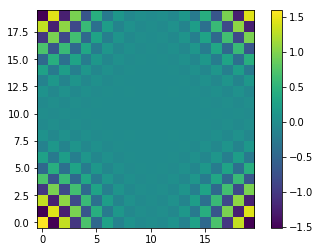

In [9]:
singlePlot(HFGauss)

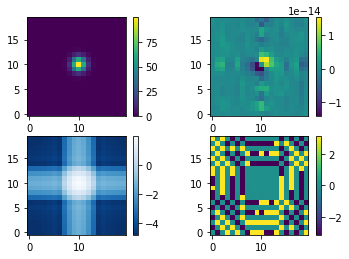

In [10]:
D = np.fft.fft2(HFGauss)
plotF(D)

## Floating point optimisation for a convolution kernel


1. Shift to high frequency by sign multiplication oscillation
2. FFT
3. Do the same for the image
4. Do the operation
5. IFFT
6. Sign multiplication to shift down frequencies in real space

Or, instead of steps 1-2: FFT -> then fftshift

I don't see which approach gives the best numerical result if we don't have something in frequency space a priori (like a filter with a known frequency profile).


# Image deconvolution
We demonstrate the inverse operation of a Gaussian convolution by inverting it in Fourier space. Also we show how the deconvolution kernel looks in real space.

This operation is numerically less and less viable if the blur is wider and wider: The convolution kernel will be more and more narrow in Fourier space, so its reciprocal will go to 1/0 in high frequency parts.

## Now generate an image

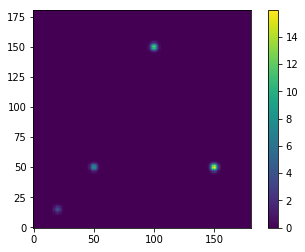

In [11]:
# The image is 181 x 181, the kernel is 20x20, padded size is 200x200
img = genImg()
singlePlot(img)

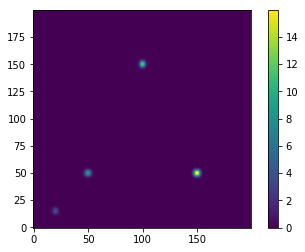

In [12]:
# Minimum padding
imgp = np.pad(img,((0,19),),mode='edge')

singlePlot(imgp)

Now we do not focus on shifting to the high frequency regime; do everything in their natural (low) frequency range

In [13]:
# 0th (first) axis is y direction, 1st (second) is x direction
yy,xx = np.mgrid[-1:1:0.1,-1:1:0.1]
pos = np.empty(xx.shape + (2,))
pos[:,:,0] = xx
pos[:,:,1] = yy
dist = stats.multivariate_normal([0,0],[[0.1,0],[0,0.1]])
tDGauss = dist.pdf(pos)
ZCentered = np.fft.fftshift(tDGauss)

Center around the origin which is in the four corners of the image

In [14]:
paddedK = np.zeros((200,200),dtype=float)
paddedK[:10,:10] = ZCentered[:10,:10]
paddedK[:10,-10:] = ZCentered[:10,10:]
paddedK[-10:,:10] = ZCentered[10:,:10]
paddedK[-10:,-10:] = ZCentered[10:,10:]

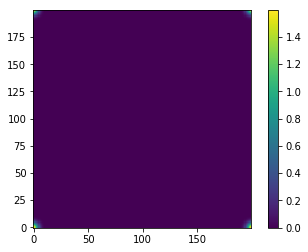

In [15]:
singlePlot(paddedK)

In [16]:
fImg = np.fft.fft2(imgp)
fK = np.fft.fft2(paddedK)

In [17]:
fconv = fImg * fK

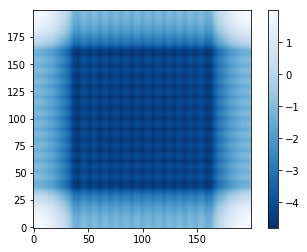

In [18]:
# Let's see how the convolution kernel looks in Fourier space.
# Note that the high value part goes beyond the 10x10 corners and there is structure "inside", too 
# (which is a result of the cutting to zero at the 10x10, a kind of window function)
singlePlotLog(fK)

Now get the convolved image back to real space

In [19]:
conv = np.real(np.fft.ifft2(fconv))

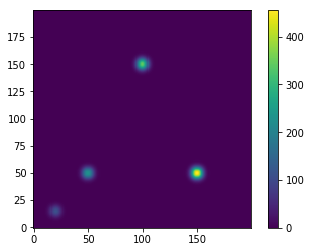

In [20]:
singlePlot(conv)

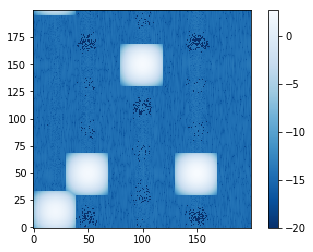

In [21]:
singlePlotLog(conv)

In [22]:
import scipy.ndimage

Now perform the convolution directly in image space
Default is to "reflect" at the border.

In [23]:
DConv = scipy.ndimage.convolve(img,tDGauss)

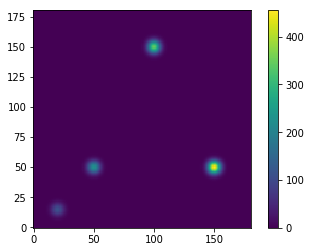

In [24]:
singlePlot(DConv)

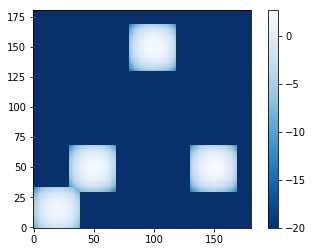

In [25]:
singlePlotLog(DConv)

Crop the padding for comparison

In [26]:
# Cut off the padding
conv = conv[:181,:181]

In [27]:
diff = conv - DConv

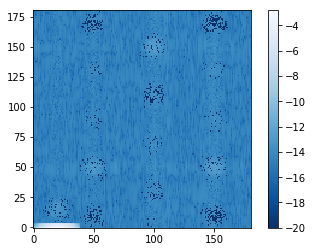

In [28]:
singlePlotLog(diff)

The direct convolution and the Fourier convolution differs where the boundary condition was different; the direct convolution uses the default boundary condition 'reflect'.

Now reverse the opration in FFT space


In [29]:
# Pad the image again; we lose the extra bit of result that was in the padded area
conv =  np.pad(conv,((0,19),),mode='edge')
fconv = np.fft.fft2(conv)
fconv /= fK
recon = np.real(np.fft.ifft2(fconv))

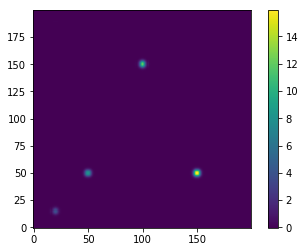

In [30]:
singlePlot(recon)

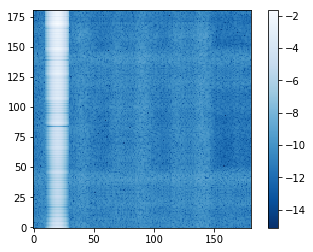

In [31]:
singlePlotLog(recon[:181,:181]-img)

* The information of the chopped edge of the bottom source is now missing in the deconvolution.

Check out deconvolution kernel in real space

In [32]:
deconvK = np.fft.ifft2(1/fK)

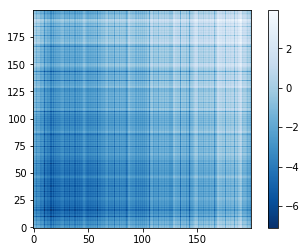

In [33]:
singlePlotLog(deconvK)

Now center back the deconvolution kernel in real space

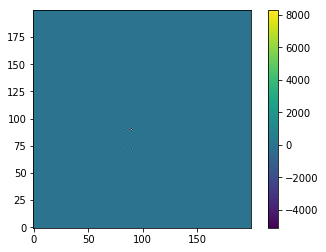

In [34]:
deconvKC = np.real(np.fft.ifftshift(deconvK))
singlePlot(deconvKC)

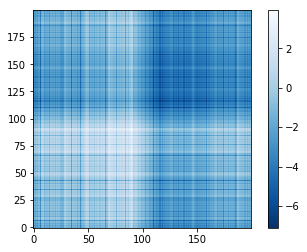

In [35]:
singlePlotLog(deconvKC)

Use this "kernel" to direct deconvolution

In [36]:
dRecon = scipy.ndimage.convolve(conv,deconvKC,mode='constant')

In [37]:
dRecon.shape

(200, 200)

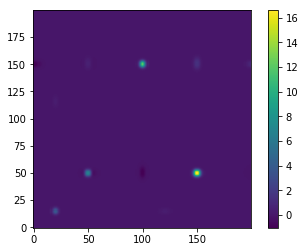

In [38]:
singlePlot(dRecon)

Looks good, but there are some aliasing.

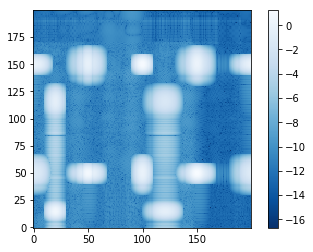

In [39]:
singlePlotLog(dRecon)

In [40]:
dRecon = scipy.ndimage.convolve(conv,deconvKC,mode='wrap')

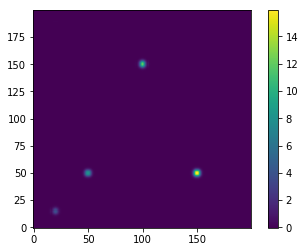

In [41]:
singlePlot(dRecon)

Now better, with the same circular boundary condition.

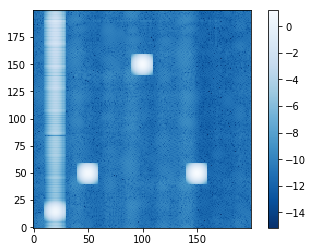

In [42]:
singlePlotLog(dRecon)

The Fourier space derived inverse do assume that the image is repeated.

Difference from the original image

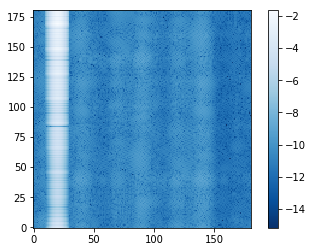

In [43]:
singlePlotLog(dRecon[:181,:181]-img)

Direct deconvolution vs. DFT deconvolution:

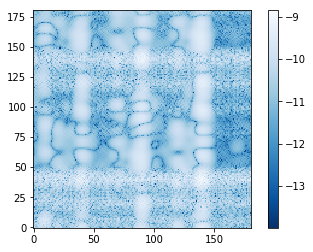

In [44]:
singlePlotLog(recon[:181,:181] - dRecon[:181,:181],minVal=1e-14)

They're the same within the floating point precision (epsilon * num of pix.): 1e-16 * 4e+05 -> 1e-11

---------

Now let's see whether the result any good if we just use the original 20x20 part of the deconvolution kernel

Cut out the corners of the deconvolution kernel and put together:

In [45]:
deconvK_r = np.real(deconvK)
sdecorr2 = np.zeros((20,20),dtype=float)
sdecorr2[:10,:10] = deconvK_r[:10,:10]
sdecorr2[:10,10:] = deconvK_r[:10,-10:]
sdecorr2[10:,:10] = deconvK_r[-10:,:10]
sdecorr2[10:,10:] = deconvK_r[-10:,-10:]
sdecorr2C = np.fft.ifftshift(sdecorr2)

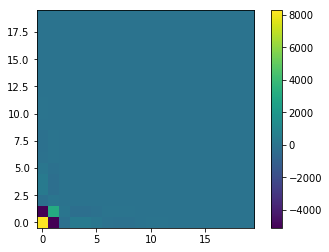

In [46]:
singlePlot(sdecorr2C)

In [47]:
dRecon2 = scipy.ndimage.convolve(conv,sdecorr2C,mode='wrap')

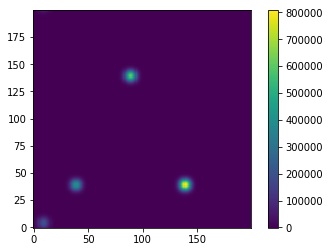

In [48]:
singlePlot(dRecon2)

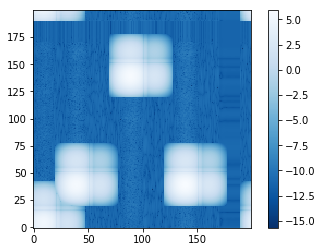

In [49]:
singlePlotLog(dRecon2)

Let's see what happend if we calculate the deconvolution kernel on its own 20x20 space

In [50]:
sfK = np.fft.fft2(ZCentered)
sdK = np.fft.ifft2(1./sfK)
sdK = np.real(np.fft.ifftshift(sdK))

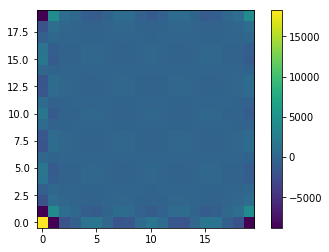

In [51]:
singlePlot(sdK)

In [52]:
dRecon3 = scipy.ndimage.convolve(DConv,sdK,mode='wrap')

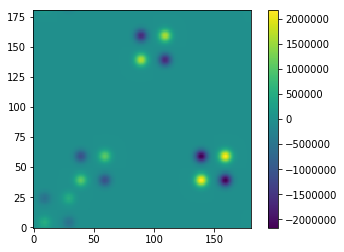

In [53]:
singlePlot(dRecon3)

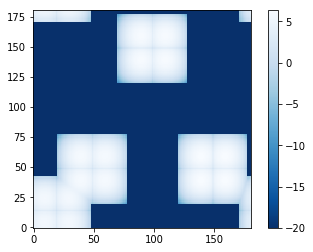

In [54]:
singlePlotLog(dRecon3)

-------------

Check out no zero centering; this is basically what we do in the code

In [55]:
# Centered before DFT
sfK = np.fft.fft2(tDGauss)
sdK = np.fft.ifft2(1./sfK)
sdK = np.real(np.fft.ifftshift(sdK))
#sdK = np.real(sdK)

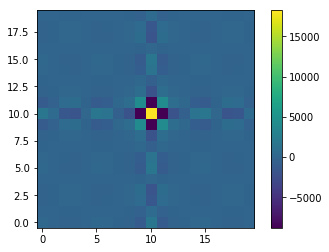

In [56]:
singlePlot(sdK)

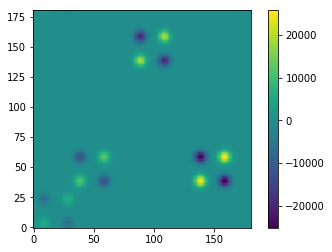

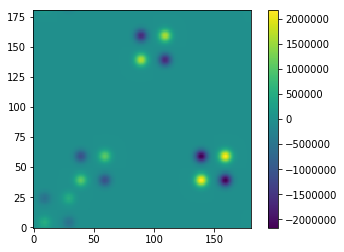

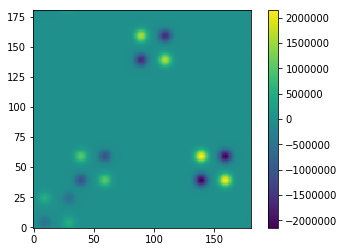

In [57]:
dRecon4 = scipy.ndimage.convolve(DConv,sdK,mode='wrap')
dRecon5 = scipy.ndimage.convolve(DConv,np.fft.fftshift(sdK),mode='wrap')

singlePlot(dRecon4)
singlePlot(dRecon5)
singlePlot(dRecon4-dRecon5)

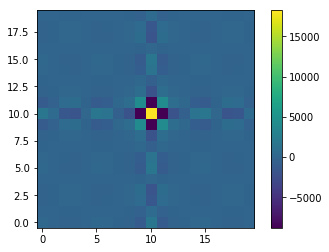

In [58]:
singlePlot(sdK)

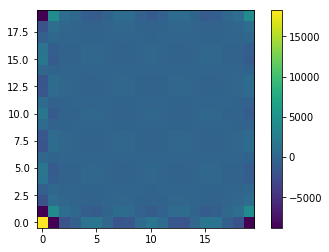

In [59]:
singlePlot(np.fft.fftshift(sdK))

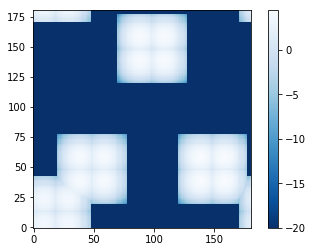

In [60]:
singlePlotLog(dRecon4)

Here we show that a shifting a signal towards the center increase phase variation, max in the middle

--------------

# Decorrelation afterburner correction

We repeat a similar exercise and compare here how an unpadded and padded decorrelation afterburner correction looks like


In [61]:
# 0th (first) axis is y direction, 1st (second) is x direction
yy,xx = np.mgrid[-1:1:0.1,-1:1:0.1]

pos = np.empty(xx.shape + (2,))
pos[:,:,0] = xx
pos[:,:,1] = yy
dist = stats.multivariate_normal([0,0],[[0.1,0],[0,0.1]])
tDGauss = dist.pdf(pos)

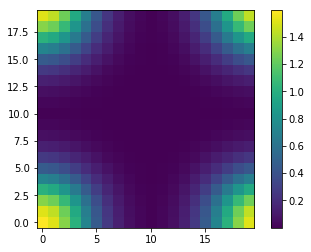

In [62]:
ZCentered = np.fft.fftshift(tDGauss)
singlePlot(ZCentered)

In [63]:
sigma1 = 1. # Template
sigma2 = 10. # Science image
r = sigma1/sigma2 # Science image convolution case
vr = r*r
print(vr)

0.010000000000000002


In [64]:
fK1 = np.fft.fft2(ZCentered)
fPsi1 = np.sqrt((vr + 1)/(vr + np.conj(fK1)*fK1))

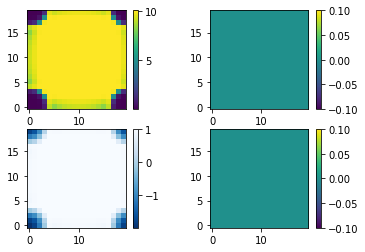

In [65]:
plotF(fPsi1)

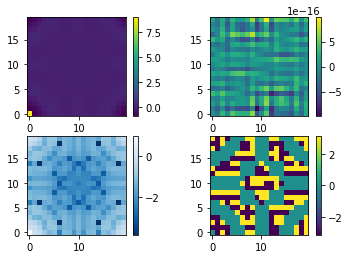

In [66]:
kdecorr1 = np.fft.ifft2(fPsi1)
plotF(kdecorr1)

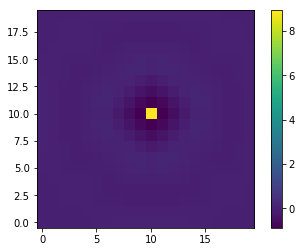

In [67]:
kdecorr1 = np.fft.ifftshift(np.real(kdecorr1))
singlePlot(kdecorr1)

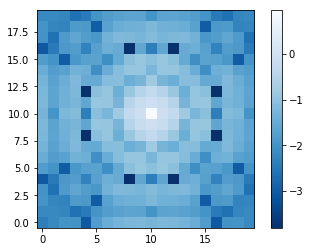

In [68]:
singlePlotLog(kdecorr1)

## Now do it with padding


In [69]:
paddedK = np.zeros((200,200),dtype=float)
paddedK[:10,:10] = ZCentered[:10,:10]
paddedK[:10,-10:] = ZCentered[:10,10:]
paddedK[-10:,:10] = ZCentered[10:,:10]
paddedK[-10:,-10:] = ZCentered[10:,10:]

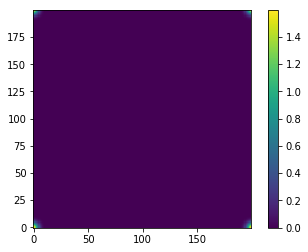

In [70]:
singlePlot(paddedK)

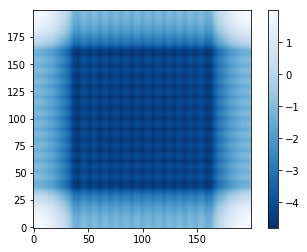

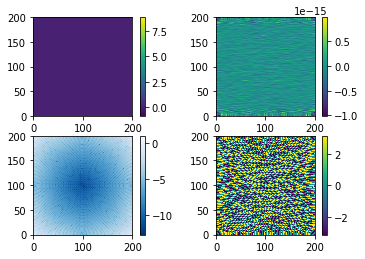

In [71]:
fK2 = np.fft.fft2(paddedK)
singlePlotLog(fK2)
fPsi2 = np.sqrt((vr + 1)/(vr + np.conj(fK2)*fK2))
pkdecorr2 = np.fft.ifft2(fPsi2)
plotF(pkdecorr2)

## Note:
The DFT transform goes well beyond the 10x10 edges

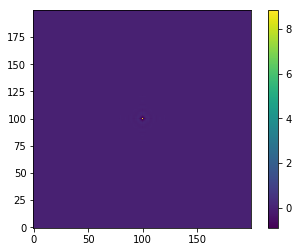

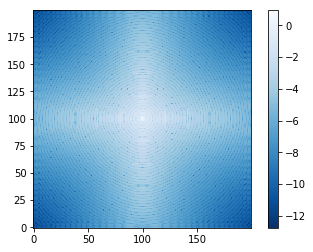

In [72]:
pkdecorr2 = np.fft.ifftshift(np.real(pkdecorr2))
singlePlot(pkdecorr2)

singlePlotLog(pkdecorr2)